reference:
https://blog.amedama.jp/entry/hyperopt

In [29]:
# basic
import numpy as np
import pandas as pd

# plot
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
import pprint

# model
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR

# optimization
from functools import partial
from sklearn.model_selection import KFold
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as MSE

# importance
import eli5
from eli5.sklearn import PermutationImportance

# other
import pickle
import time
import datetime

In [3]:
train = pd.read_pickle('../features/feature_train_2020-11-07-08-04-37_treated.pkl')
test = pd.read_pickle('../features/feature_test_2020-11-07-08-04-37_treated.pkl')
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])

In [44]:
def RMSE(y_true, y_pred):
    return(np.sqrt(MSE(y_true, y_pred)))

In [45]:
def score(X, y, args):
    model = SVR(kernel='rbf', **args)
    
    kf = KFold(n_splits=4, shuffle=True, random_state=1)
    
    score_func = {
        'custom_rmse':make_scorer(RMSE)
    }
    
    scores = cross_validate(model, X=X, y=y, cv=kf, scoring=score_func)
    
    #model.fit(X=X_train, y=Y_train)
    #Y_pred = model.predict(X_valid)
    #scores = np.sqrt(MSE(y_true=Y_valid, y_pred=Y_pred))
    #print(f'params: {params}, scores:{scores:.4f}')
    
    history.append((model, scores))
    
    return {'loss':scores['test_custom_rmse'].mean(), 'status':STATUS_OK, 'params':args}

In [48]:
history = []
#best = []

X = train.drop(['id', 'mpg'], axis=1)
y = train['mpg']

f = partial(score, X, y)

param_space = {
    'C': hp.loguniform(
        label='C', low=np.log(1e-8), high=np.log(1.0)
    ),
    'gamma': hp.loguniform(
        label='gamma', low=np.log(1e-8), high=np.log(1.0)
    ),
    'epsilon':hp.loguniform(
        label='epsilon', low=np.log(1e-8), high=np.log(1)
    )
}

trials=Trials()

best = fmin(
    fn=f,
    space=param_space, 
    algo=tpe.suggest,
    max_evals=10,
    trials=trials
)

#history = sorted(history, key=lambda tpl:tpl[1])
#best.append(history[0])

100%|████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.47trial/s, best loss: 7.5492759834531595]


In [47]:
for i, hist_i in enumerate(history):
    print("No.", i)
    print(hist_i[1]['test_custom_rmse'], hist_i[1]['test_custom_rmse'].mean())

No. 0
[7.62930038 7.27042254 7.62921693 8.13047661] 7.664854114361842
No. 1
[7.62928174 7.27039984 7.62920581 8.13044223] 7.664832404819318
No. 2
[7.62930142 7.27042333 7.62921772 8.13047743] 7.664854976280326
No. 3
[7.68646867 7.27231471 7.62871899 8.01608581] 7.650897045423447
No. 4
[7.62709414 7.26899539 7.62772576 8.12947995] 7.663323808427185
No. 5
[7.62927904 7.27040384 7.6291995  8.12937953] 7.664565477390157
No. 6
[7.6916385  7.26990785 7.62835752 8.00741362] 7.649329372425033
No. 7
[7.61874197 7.25489565 7.61675462 8.11314473] 7.650884243040471
No. 8
[7.60844486 7.24847908 7.60904611 8.10296954] 7.642234899375499
No. 9
[6.21266287 6.0720885  7.01908204 6.50982628] 6.45341492159718


In [49]:
# 結果を出力する
print('best parameters:', space_eval(param_space, best))

best parameters: {'C': 0.006707078999822721, 'epsilon': 0.00018687194961404454, 'gamma': 5.1188685526163025e-06}


In [50]:
# 探索過程を可視化する
xs = [result['params']['C'] for result in trials.results]
ys = [result['params']['gamma'] for result in trials.results]
zs = np.array([-1 * result['loss'] for result in trials.results])
s_zs = (zs - zs.min()) / (zs.max() - zs.min()) # 0 ~ 1 の範囲に正規化する

findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.


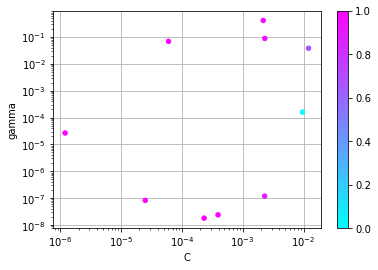

-- accuracy summary --
count    10.000000
mean      0.073950
std       0.000338
min       0.073037
25%       0.074008
50%       0.074089
75%       0.074116
max       0.074117
dtype: float64


In [13]:
# プロットする
sc = plt.scatter(xs, ys, c=s_zs, s=20, zorder=10, cmap=cm.cool)
plt.colorbar(sc)

plt.xlabel('C')
plt.xscale('log')
plt.ylabel('gamma')
plt.yscale('log')
plt.grid()
plt.show()

print('-- accuracy summary --')
print(pd.Series(np.array(zs).ravel()).describe())